In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage as ndi
import cv2
from PIL import Image
import os
import random

from skimage import data
from skimage.color import rgb2hsv, rgb2gray
from utils import load_input_image
from segmentation import Segementation

In [2]:
def load_textures(folder="train2_solutions", path="data_project"):
    paths = os.path.join(path, folder)
    files = os.listdir(paths)
    list_textures = []
    for file in files:
        if file.startswith("solution"):
            im = Image.open(f"{paths}/{file}").convert("RGB")
            list_textures.append(np.array(im))
    return list_textures

In [3]:
textures = load_textures()

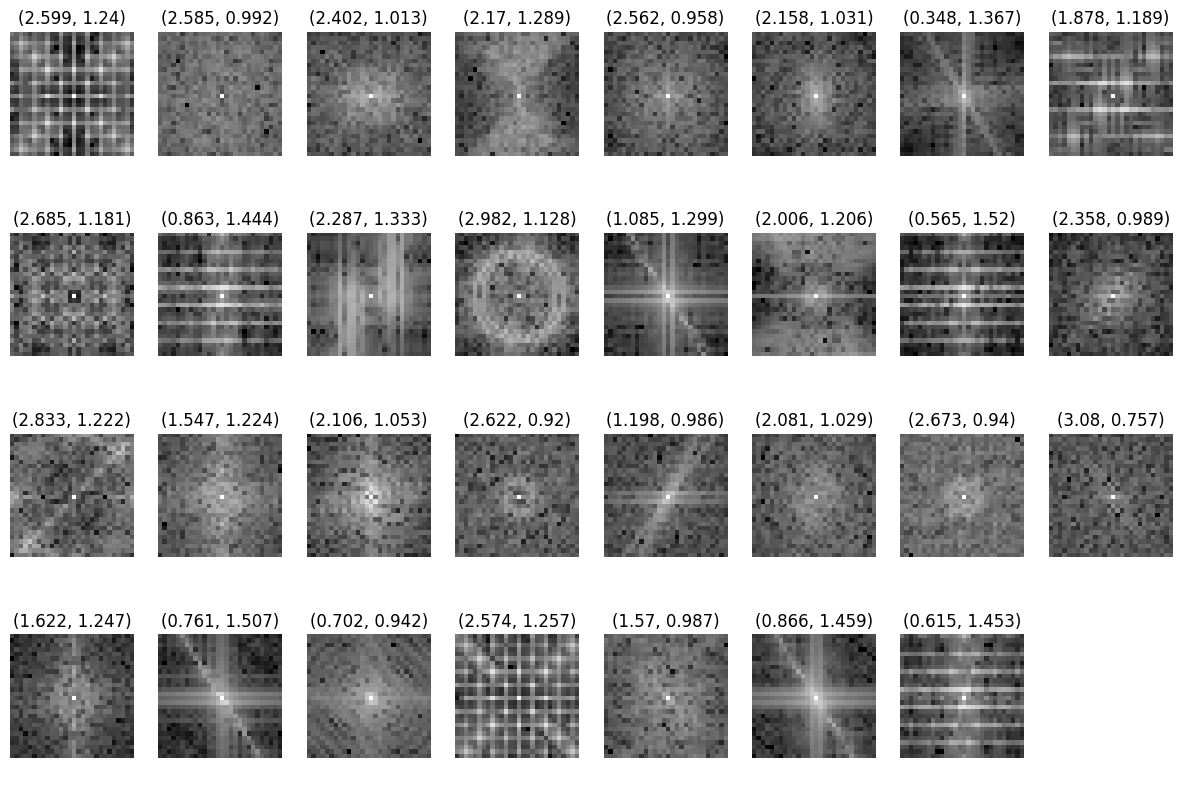

In [4]:
l = 0
fig, axes = plt.subplots(4, 8, figsize=(15, 10))
for img, ax in zip(textures, axes.ravel()):
    index1 = random.randint(0, 2 * 128)
    index2 = random.randint(0, 2 * 128)
    transform = np.fft.fft2(rgb2gray(img[index1 : 128 + index1, index2 : 128 + index2]))
    fshift = np.fft.fftshift(transform)
    ax.imshow(np.log(np.abs(fshift[50:-50, 50:-50])), cmap="gray")
    ax.axis("off")
    ax.set_title(
        (
            round(np.mean(np.log(np.abs(fshift[25:-25, 25:-25]))),3),
            round(np.std(np.log(np.abs(fshift[25:-25, 25:-25]))),3),
        )
    )  # [l:-l,l:-l]
axes[3, 7].axis("off")
plt.show()

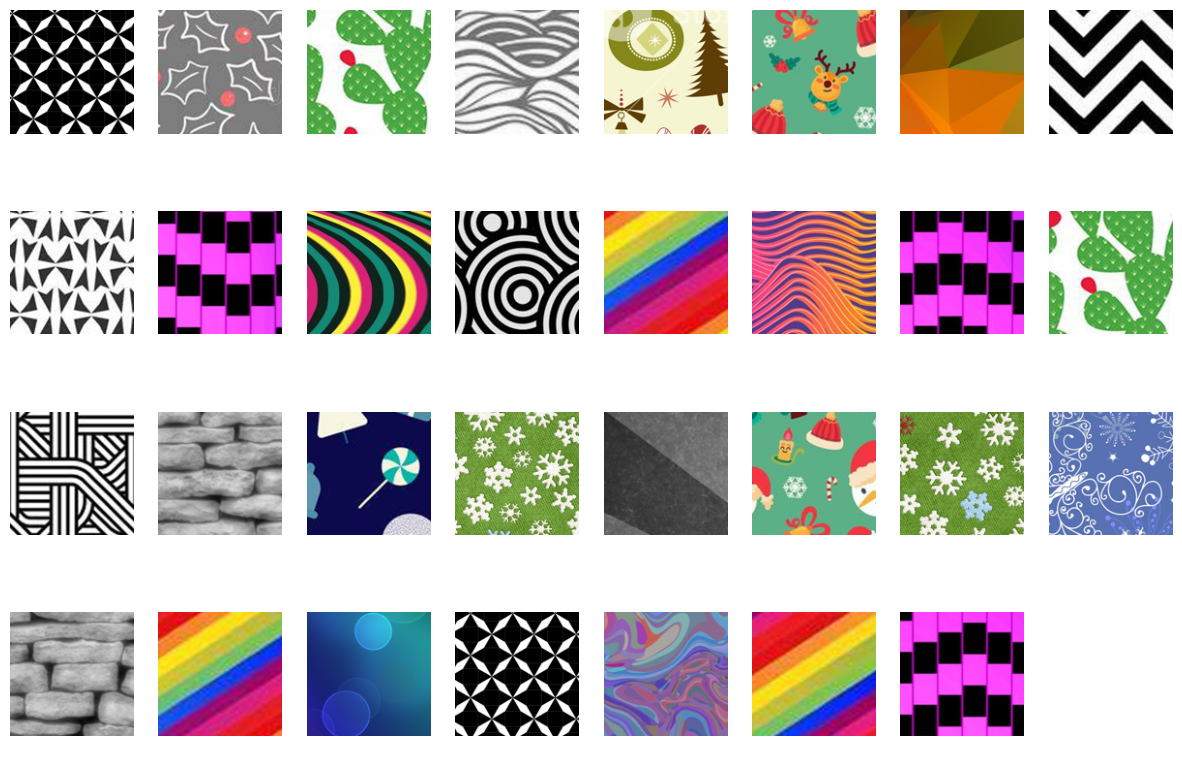

In [5]:
fig, axes = plt.subplots(4,8, figsize=(15,10))
for img,ax in zip(textures,axes.ravel()):
    index1 = random.randint(0, 2*128)
    index2 = random.randint(0, 2*128)
    ax.imshow(img[index1:128+index1,index2:128+index2])
    ax.axis("off")
axes[3,7].axis("off")
plt.show()

In [6]:
imgs = {i: load_input_image(i,folder="train2") for i in range(12)}

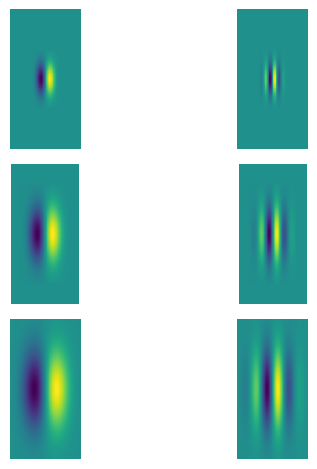

In [7]:
gamma = 0.5
phi = np.pi / 2
nth = 1
theta = 0

ksize = [20, 35, 50]
freqs = [1,3]

fig, axs = plt.subplots(len(ksize), len(freqs))
for i, k in enumerate(ksize):
    sigma = 2 * k / 10
    for j, f in enumerate(freqs):
        lamda = k / f
        kernel = cv2.getGaborKernel((k, 2*k), sigma, theta, lamda, gamma, phi)
        kernel_pad = np.pad(
            kernel,
            (
                ((max(ksize) - k) , (max(ksize) - k) ),
                ((max(ksize) - k) //2, (max(ksize) - k) // 2),
            ),
            constant_values=0,
        )
        axs[i, j].imshow(kernel_pad)
        axs[i, j].axis("off")
plt.tight_layout()
plt.show()

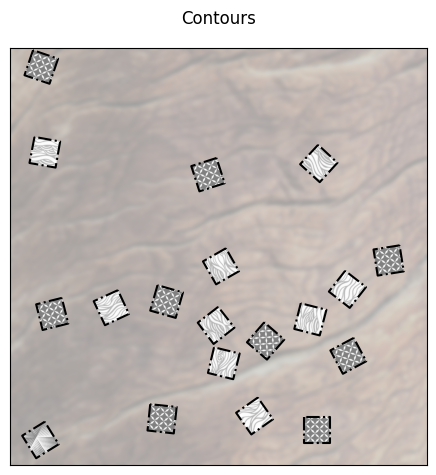

In [8]:
img = imgs[11]
seg = Segementation(img)
seg.find_pieces()
seg.plot_contours()

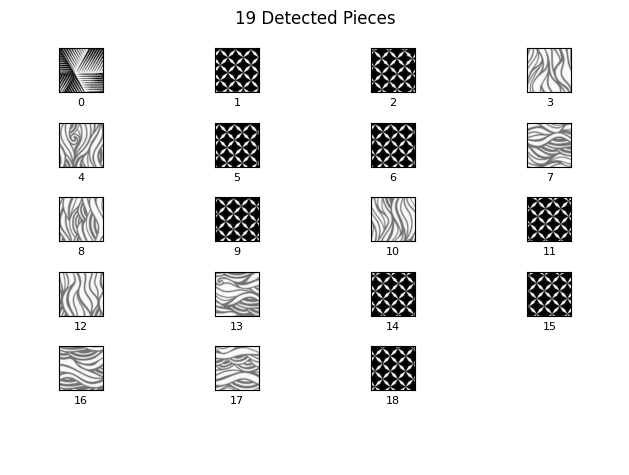

In [9]:
seg.plot_pieces()

In [10]:
#Piece 11
pieces_1 = [1,2,5,6,9,11,14,15,18]
pieces_2 = [3,4,7,8,10,12,13,16,17]
pieces_3 = []
outliers = [0]
indexes = [pieces_1,pieces_2,pieces_3,outliers]

In [11]:
def get_features(img):
    # COLOR
    img_hsv = rgb2hsv(img)
    means = np.median(img, axis=(0, 1))
    std = np.std(img, axis=(0, 1))
    means_hsv = np.median(img_hsv, axis=(0, 1))
    std_hsv = np.std(img_hsv, axis=(0, 1))

    # FOURIER
    transform = np.fft.fft2(rgb2gray(img))
    fshift = np.fft.fftshift(transform)
    np.log(np.abs(fshift[50:-50, 50:-50]))

    ft_mean = np.mean(np.abs(fshift[50:-50, 50:-50]))
    ft_std = np.std(np.abs(fshift[50:-50, 50:-50]))

    # GABOR
    gamma = 0.5
    phi = np.pi / 2
    ksizes = [20, 40, 60]
    nth = 12
    thetas = np.linspace(0, np.pi, nth)
    freqs = [1, 3]

    means_gabor = []
    std_gabor = []
    thetas_max = []
    for ksize in ksizes:
        sigma = 2 * k / 10
        for f in freqs:
            lamda = k / f
            mean_max = np.zeros((1,3))
            std_max = np.zeros((1,3))
            theta_max = 0
            for theta in thetas:
                kernel = cv2.getGaborKernel(
                    (ksize, 2*ksize), sigma, theta, lamda, gamma, phi
                )
                f_img = cv2.filter2D(rgb2hsv(img), cv2.CV_8UC3, kernel)
                means_f = np.mean(np.abs(f_img), axis=(0, 1))
                if np.sum(means_f) > np.sum(mean_max):
                    std_max = np.std(np.abs(f_img), axis=(0, 1))
                    theta_max = theta
                    mean_max = means_f
            means_gabor.extend(list(mean_max))
            std_gabor.extend(list(std_max))
            thetas_max.append(theta_max % (np.pi / 2))

    return np.hstack(
        [
            means,
            std,
            means_hsv,
            std_hsv,
            means_gabor,
            std_gabor,
            thetas_max,
            ft_mean,
            ft_std,
        ]
    )

In [12]:
features = np.array([get_features(seg.pieces[i]) for i in range(len(seg.pieces))])
features = (features - np.mean(features, axis=0)) / np.maximum(1e-10, np.std(features, axis=0))
features.shape

(19, 56)

In [13]:
from sklearn.decomposition import PCA, KernelPCA

pca = KernelPCA(n_components=3,kernel="rbf")
features_PCA = pca.fit_transform(features)
#print(pca.explained_variance_ratio_)

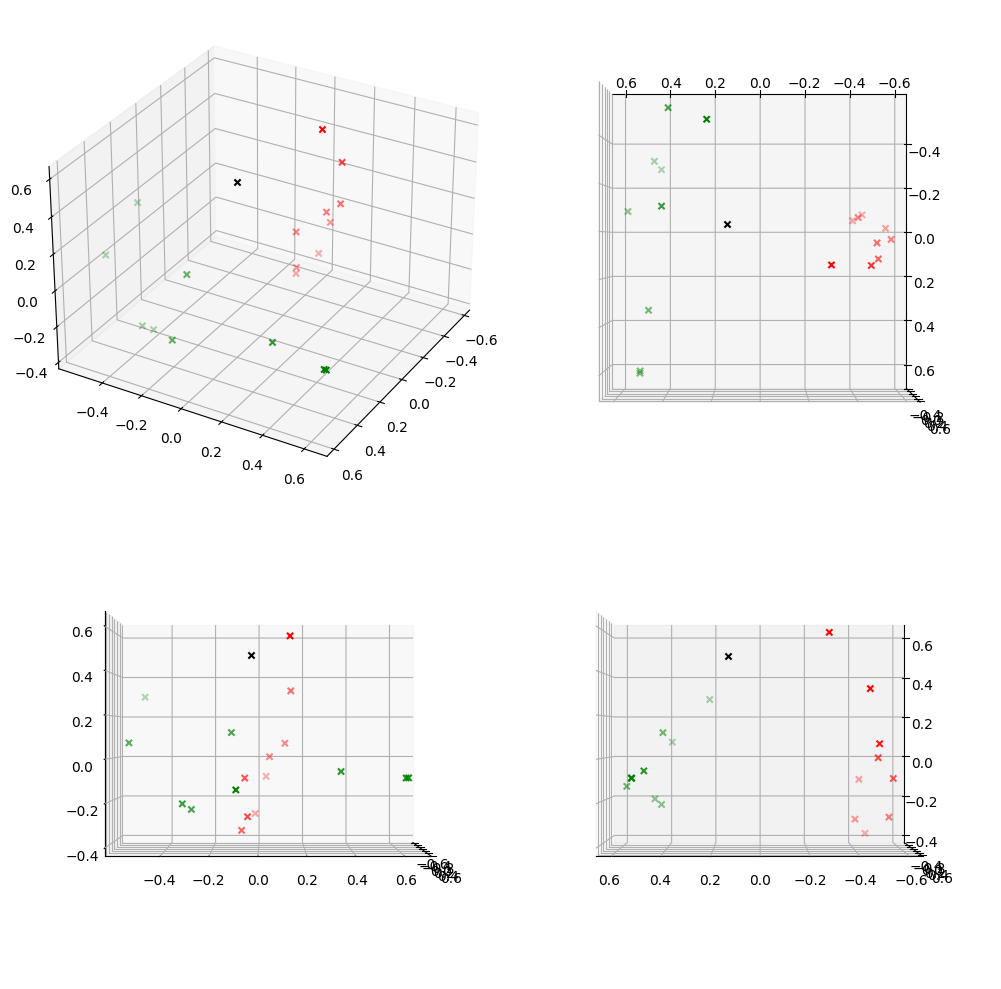

In [14]:
import matplotlib.pyplot as plt

colors = ["r", "g", "b", "k", "c", "m"]
orientation = [(30, 30), (90, 90), (0, 0), (0, 90)]

fig = plt.figure(figsize=(10, 10))
for i, o in enumerate(orientation):
    ax = fig.add_subplot(2, 2, i + 1, projection="3d")
    for j, index in enumerate(indexes):
        ax.scatter(*features_PCA[index].T, c=colors[j], marker="x")
        ax.view_init(elev=o[0], azim=o[1])

plt.tight_layout()
plt.show()

In [15]:
from sklearn.mixture import GaussianMixture
gm =GaussianMixture(n_components=3)
labels = gm.fit_predict(features_PCA)
labels

array([0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 2, 1, 0, 2, 1, 1, 0, 2, 1])

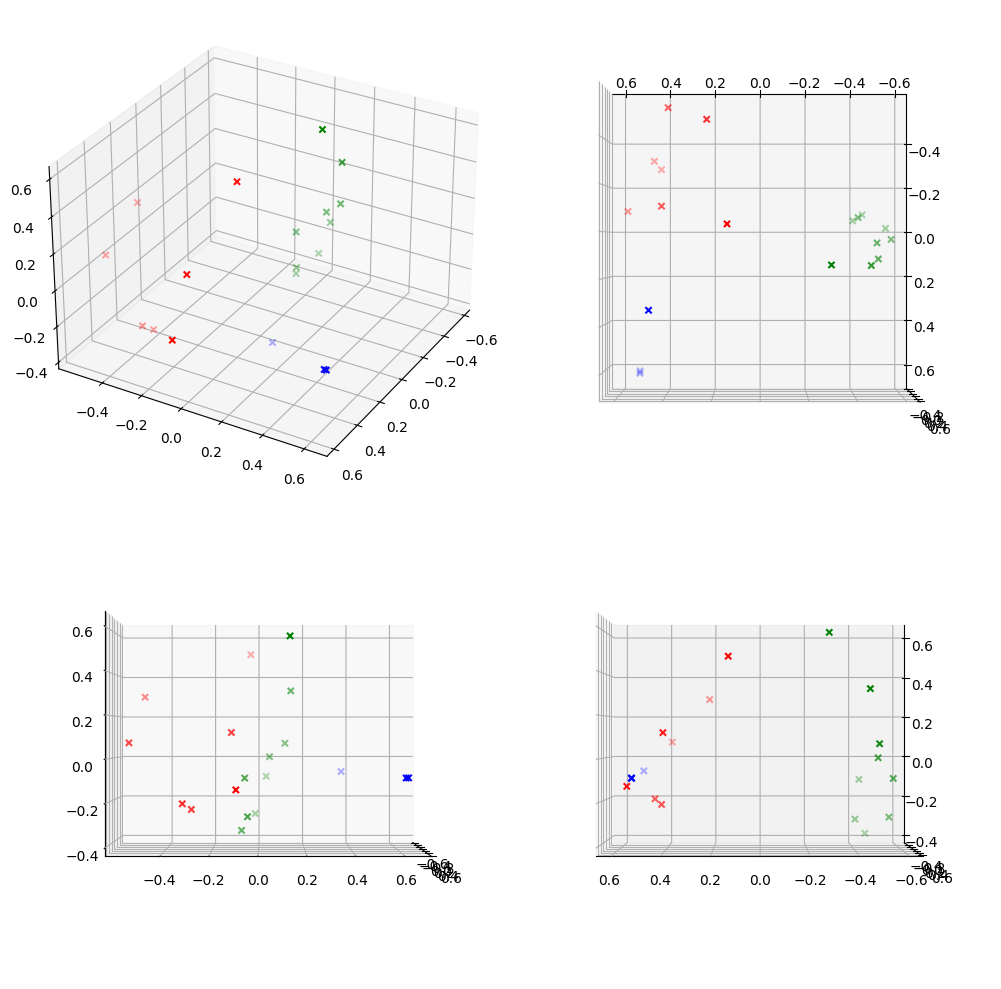

In [16]:
fig = plt.figure(figsize=(10,10))


for i, o in enumerate(orientation):
    ax = fig.add_subplot(2,2,i+1, projection='3d')
    for label in np.unique(labels):
        ax.scatter(*features_PCA[labels==label].T, c=colors[label], marker='x')
        ax.view_init(elev=o[0], azim=o[1])

plt.tight_layout()
plt.show()

In [17]:
from sklearn.cluster import OPTICS, DBSCAN
clustering = DBSCAN(eps=0.5, min_samples=5)
labels = clustering.fit_predict(features_PCA)
labels

array([1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0])

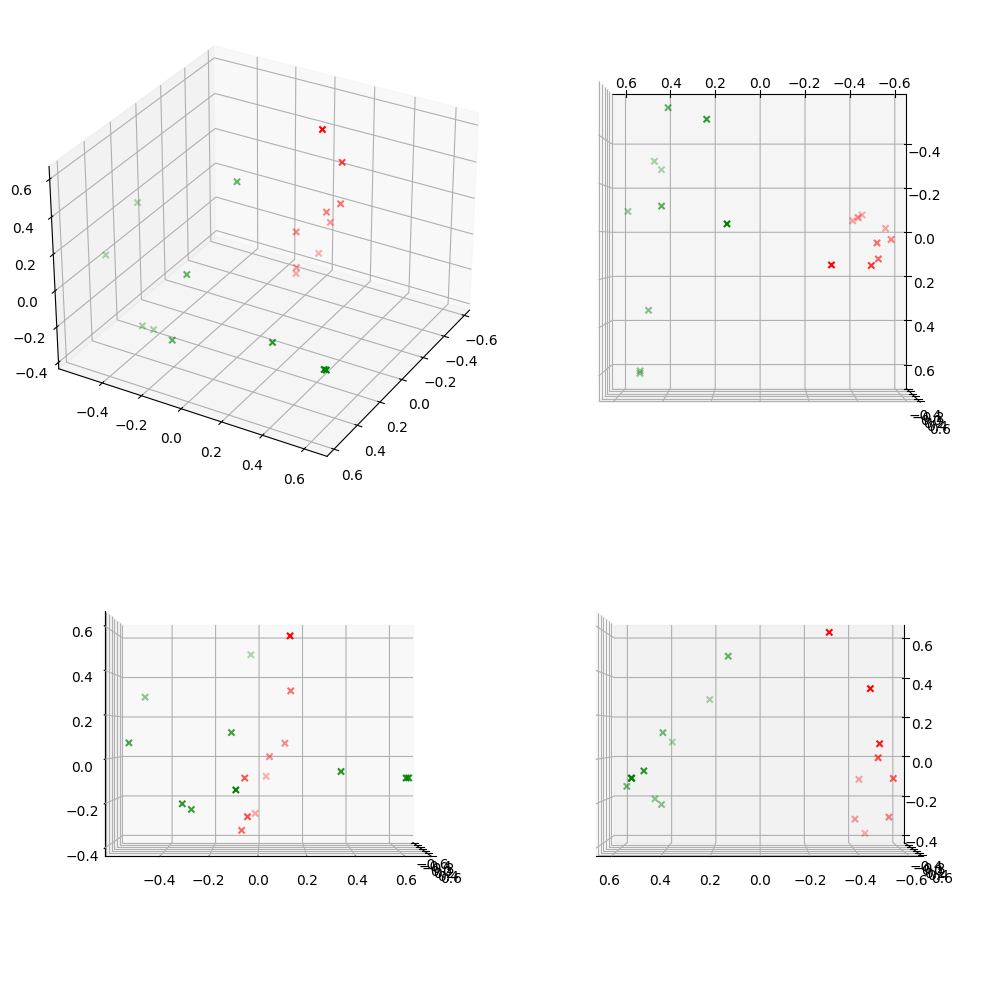

In [18]:
fig = plt.figure(figsize=(10,10))
for i, o in enumerate(orientation):
    ax = fig.add_subplot(2,2,i+1, projection='3d')
    for label in np.unique(labels):
        ax.scatter(*features_PCA[labels==label].T, c=colors[label], marker='x')
        ax.view_init(elev=o[0], azim=o[1])

plt.tight_layout()
plt.show()

In [19]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, n_init=10)
labels = kmeans.fit_predict(features_PCA)
labels

array([2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 0, 1, 2, 0, 1, 1, 2, 0, 1],
      dtype=int32)

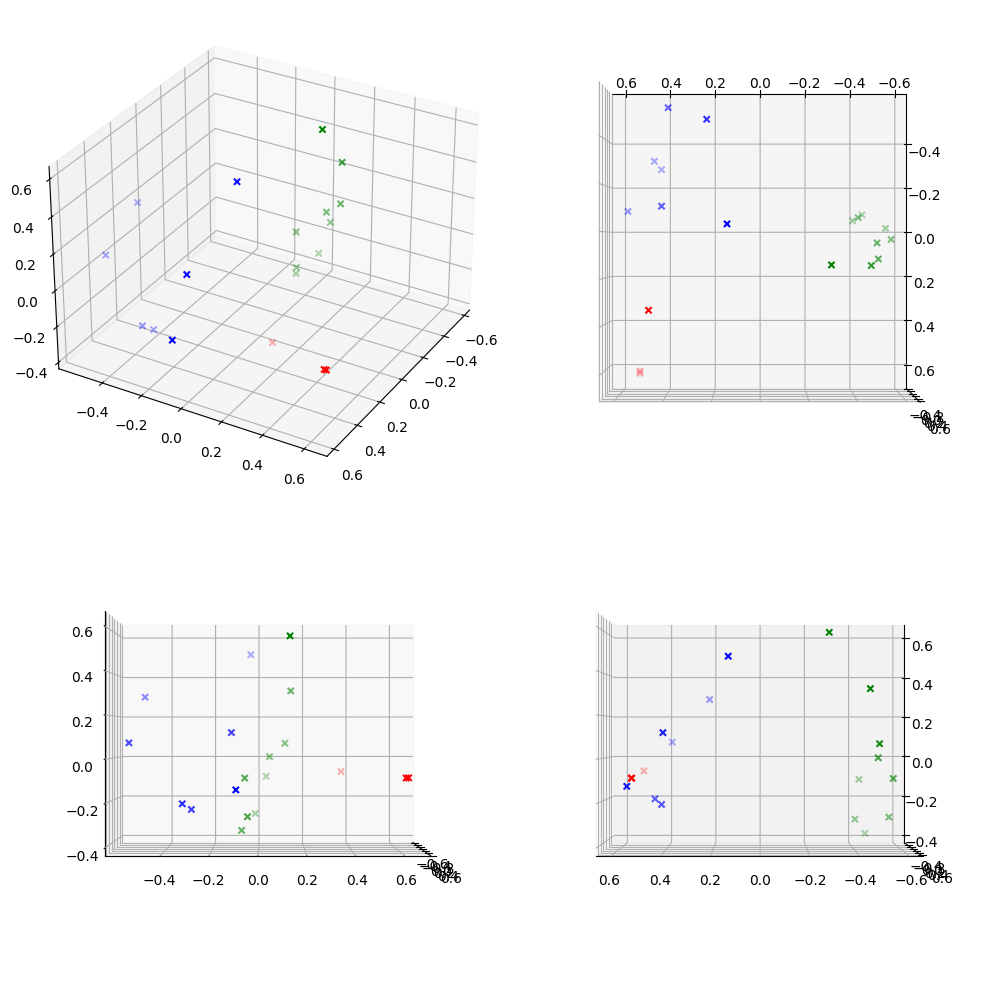

In [20]:
fig = plt.figure(figsize=(10,10))
for i, o in enumerate(orientation):
    ax = fig.add_subplot(2,2,i+1, projection='3d')
    for label in np.unique(labels):
        ax.scatter(*features_PCA[labels==label].T, c=colors[label], marker='x')
        ax.view_init(elev=o[0], azim=o[1])

plt.tight_layout()
plt.show()

In [21]:
#Piece 0
pieces_1 = [0,2,8,9,10,12,13,14,19]
pieces_2 = [1,5,6,11,16,21,22,25,26]
pieces_3 = [3,4,7,15,17,18,20,24,27]
outliers = [23]
indexes = [pieces_1,pieces_2,pieces_3,outliers]

In [22]:
#Piece 1 
pieces_1 = [2,7,4,8,10,11,12,12,14]
pieces_2 = [0,1,5,6,9,15,16,17,19]
pieces_3 = []
outliers = [3,18,20]
indexes = [pieces_1,pieces_2,pieces_3,outliers]

In [23]:
#Piece 2 
pieces_1 = [2,5,6,17,19,20,22,23,24]
pieces_2 = [1,4,9,13,15,18,21,25,26]
pieces_3 = [3,7,8,10,11,12,14,16,27]
outliers = [0]
indexes = [pieces_1,pieces_2,pieces_3,outliers]

In [24]:
#Piece 3
pieces_1 = [0,1,2,5,11,12,13,16,17]
pieces_2 = [3,4,6,7,8,9,15,18,20]
pieces_3 = []
outliers = [10,14,19]
indexes = [pieces_1,pieces_2,pieces_3,outliers]

In [25]:
#Piece 4
pieces_1 = [1,3,5,7,8,9,11,15,18]
pieces_2 = [2,4,6,10,12,13,14,17,19]
pieces_3 = []
outliers = [0,16]
indexes = [pieces_1,pieces_2,pieces_3,outliers]

In [26]:
#Piece 5
pieces_1 = [3,4,6,7,9,10,15,19,24]
pieces_2 = [0,8,12,14,16,17,18,20,26]
pieces_3 = [1,2,5,11,13,21,22,23,27]
outliers = [25]
indexes = [pieces_1,pieces_2,pieces_3,outliers]

In [27]:
#Piece 10
pieces_1 = [0,1,8,12,14,17,18,20,22]
pieces_2 = [2,3,4,9,10,15,16,21,23]
pieces_3 = [5,6,7,11,13,19,25,26,27]
outliers = []
indexes = [pieces_1,pieces_2,pieces_3,outliers]